<a id=top></a>
# Machine Learning with Kernels
- <a href=#deffunctions>Some needed functions</a>
- <a href=#getdata>Obtain and visually inspect Fisher's Iris Data</a>
- <a href=#featengine>Feature Engineering</a>
- <a href=#logisticregression>Model Fisher's Iris Data with Logistic Regression</a>
- <a href=#kernelsvm>Model Fisher's Iris Data with the Kernel Support Vector Machine</a>
- <a href=#crossval>Machine Learning Technique - Cross-validation</a>
- <a href=#gridsearch>Hyperparameter Tuning - Grid Search</a>
- <a href=#featsel>Feature Selection - Combinatorial Enumeration</a>
- <a href=#ensemble>Ensemble Modeling</a>

- <a href=#bottom>Bottom</a>

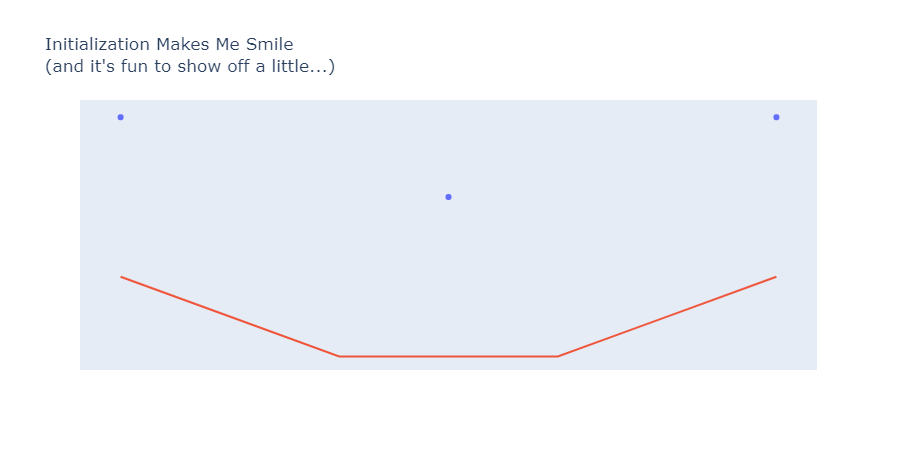

In [1]:
import math
import numpy as np
import pandas as pd
from itertools import combinations, product
from scipy import stats
from scipy.special import comb

from sklearn.datasets import load_iris, load_boston, load_diabetes
from sklearn.metrics import pairwise, confusion_matrix
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from IPython.display import display, Math

import plotly.express as px
import plotly.graph_objects as go
import chart_studio.plotly as ply
import plotly.tools as plytool
import plotly.figure_factory as ff
import plotly.offline as plyoff
import plotly.subplots as plysub

# if using jupyter lab, must have the plotly extension installed: https://github.com/jupyterlab/jupyter-renderers/tree/master/packages/plotly-extension
# jupyter labextension install @jupyterlab/plotly-extension
# to use plotly offline, need to initialize with a plot; might as well have fun with it
plyoff.init_notebook_mode(connected=True)
x1 = [1,4,7]; y1 = [7,5,7]
x2 = [1,2,3,4,5,6,7]; y2 = [3,2,1,1,1,2,3]
plyoff.iplot(go.Figure(data=[go.Scatter({'x':x1, 'y':y1, 'mode':'markers'}),
                             go.Scatter({'x':x2, 'y':y2, 'mode':'lines'})],
                                        layout=go.Layout(autosize=False,width=500,title="Initialization Makes Me Smile<br>(and it's fun to show off a little...)",
                                                         showlegend=False, xaxis={'showgrid':False, 'showticklabels':False},
                                                         yaxis={'showgrid':False, 'showticklabels':False})))

# if I want to show a df, I want to show *all* of it
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth=200

<a id=deffunctions></a>
### Some needed functions
<a href=#top>Go to top</a> - <a href=#bottom>Go to bottom</a>

In [2]:
def VarSubset(p):
    """
    Generate an array of binary indices that can be used for all-subset combinatorial analysis
    of a dataset with p features.
    ---
    Usage: subset_binaries, subset_sizes = VarSubset(p)
    ---
    p: integer indicating number of features to subset
    subset_binaries: (2^p, p) array of all subsets binary indices that can be used to subset
        into the presumed original data matrix
    subset_sizes: 2^p array indicating number of features in each subset
    ---
    ex: p = 4; cols = np.arange(p); bins,sizs = QB.VarSubset(p); print(cols[bins[8,:]])
    JAH 20060131; JAH 20121018 - ported to python; JAH 20200219 modified to use itertools.combinations
    """
    
    # check that p is int; could just duck-type it, but if user passes anything else, something is screwed up
    if type(p) is not int:
        raise ValueError("The number of features must be integer: %s"%VarSubset.__doc__)
    
    # prepare the output array; we want bool, but have to start with int, so the assignment below works correctly
    subBins = np.zeros((2**p,p),dtype=int)
    
    '''
    # slower (order of magnitude at least!) deprecated code
    # loop through all subsets :-( getting the binary representations
    for cnt in range(1,2**p):
        # get binary representation into a list, then put it in the array
        tmp = bin(cnt)[2:]
        subBins[cnt,(-len(tmp)):] = list(tmp)'''
        
    # fill in the singleton (and empty) subsets
    subBins[1:(p+1),:] = np.eye(p) # shift by 1 to have the empty subset at the beginning
    # iterate over combination cardinalities, excluding 1 & p, to fill in the subsets
    sttRow = 1+p
    for cnt in range(2,p):
        # get the cnt-length combinations
        combos = np.asarray(list(combinations(range(p), r=cnt)))
        c = len(combos)
        # create the binary vectors
        cmbBins = np.zeros(shape=(c,p))
        np.put_along_axis(cmbBins, combos, 1, axis=1)
        # store in subBins
        subBins[sttRow:(sttRow+c)] = cmbBins
        sttRow += c
    # fill in the saturated subset
    subBins[-1,:] = 1
    
    # fill in the variable counts
    subSize = np.sum(subBins,axis=1)
    
    # finally sort by variable counts
    tmp = np.argsort(subSize)
    
    return subBins[tmp,:]==1, subSize[tmp]

In [3]:
def myConfusionMatrix(y_true, y_pred, labels, names):
    # first build the confusion matrix
    dat = confusion_matrix(y_true, y_pred, labels)
    # now make and return a nice-looking dataframe   
    return pd.DataFrame(dat, columns=names, index=names)

<a id=getdata></a>
### Obtain and visually inspect Fisher's Iris Data
<a href=#top>Go to top</a> - <a href=#bottom>Go to bottom</a>

Fisher's Iris data is a famous dataset that has long been used as statisticians for classification (*supervised learning*) and clustering (*unsupervised learning*). The features are four measurements (*sepal_length*, *sepal_width*, *petal_length*, *petal_width*) taken from samples of three different varieties of iris flower (*setosa*, *versicolor*, *virginica*). For classification models, the target is to use the features to predict the variety of iris.
<center><img src="./irises.jfif" alt="Iris Varieties" width="900"/></center>


Source: Fisher, R.A. "The use of multiple measurements in taxonomic problems"
     Annual Eugenics, 7, Part II, 179-188 (1936); also in "Contributions to
     Mathematical Statistics" (John Wiley, NY, 1950).  

In [4]:
''' get the data '''
iris = load_iris()
data = iris.data
labels = iris.target
features = iris.feature_names
varieties = iris.target_names
(n,p) = data.shape
k = len(np.unique(iris.target))

# set colors by variety
colors = ['#1f77b4','#ff7f0e','#2ca02c'] # muted blue, safety orange, cooked asparagus green (WTF!)

# rename features
features = [f[:3]+'_'+f[6:9]for f in features]

# make a dataframe
cols = ['Class','Variety','Color']; cols.extend(features)
irisData = pd.DataFrame(np.c_[labels,[np.nan]*n,[np.nan]*n,data], columns=cols)
irisData = irisData.astype({'Class':int})
irisData.Variety = irisData.Class.apply(lambda x: varieties[x])
irisData.Color = irisData.Class.apply(lambda x: colors[x])

# talk
mysep='+'*42
print('Iris Data: Observations = %d, Features = %d, Classes = %d\n%s'%(n,p,k,mysep))
display(irisData.head())
print('Count by Variety\n%s'%mysep)
display(irisData.Variety.value_counts().sort_index())

Iris Data: Observations = 150, Features = 4, Classes = 3
++++++++++++++++++++++++++++++++++++++++++


,Class,Variety,Color,sep_len,sep_wid,pet_len,pet_wid
0,0,setosa,#1f77b4,5.1,3.5,1.4,0.2
1,0,setosa,#1f77b4,4.9,3.0,1.4,0.2
2,0,setosa,#1f77b4,4.7,3.2,1.3,0.2
3,0,setosa,#1f77b4,4.6,3.1,1.5,0.2
4,0,setosa,#1f77b4,5.0,3.6,1.4,0.2


Count by Variety
++++++++++++++++++++++++++++++++++++++++++


setosa        50
versicolor    50
virginica     50
Name: Variety, dtype: int64

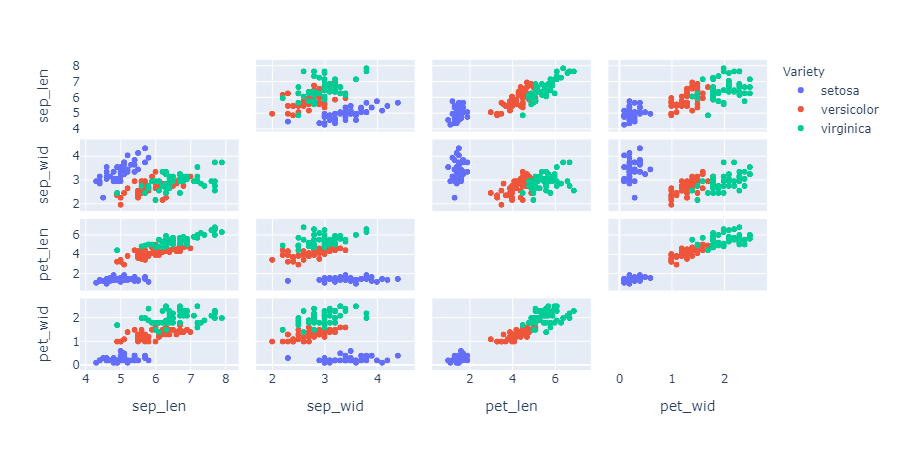

In [5]:
# scatterplot matrix
px.scatter_matrix(irisData, color='Variety', dimensions=features).update_traces(diagonal_visible=False).show()

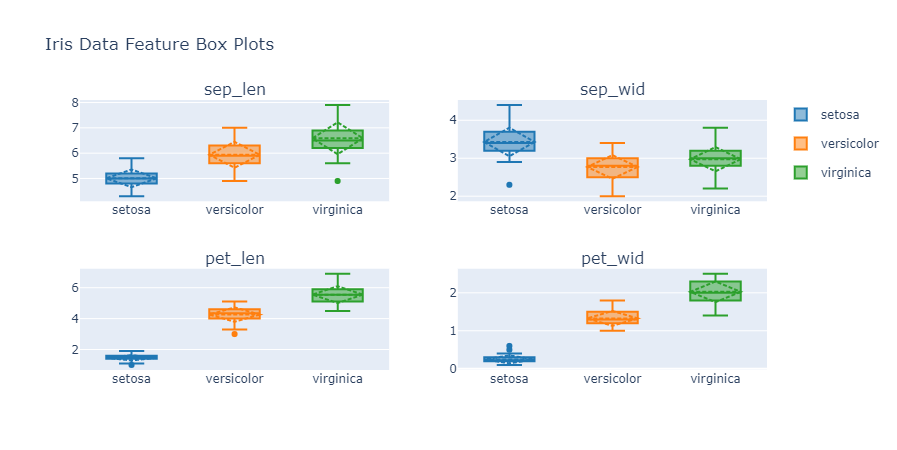

In [6]:
# show distribution of features by class
fig = plysub.make_subplots(rows=2, cols=2, subplot_titles=features, print_grid=False)
fig['layout'].update(title = 'Iris Data Feature Box Plots')

cells = [(1,1),(1,2),(2,1),(2,2)]
for i,feat in enumerate(features):
    for var,col in zip(varieties,colors):
        thisData = irisData.loc[irisData.Variety==var,feat]
        trc = go.Box(y=thisData, name=var, showlegend=(i==0), legendgroup=var,
             marker=dict(color=col), boxmean='sd', boxpoints='outliers')
        fig.append_trace(trc,cells[i][0],cells[i][1])
        
plyoff.iplot(fig)

<a id=featengine></a>
### Feature Engineering
<a href=#top>Go to top</a> - <a href=#bottom>Go to bottom</a>

**Feature Engineering** is an important part of the data science process, in which new features are computed and added to the dataset, as functions of existing observed features. Examples include pairwise interactions, higher orders, or discretizations. There would be different reasons for engineering features such as these, depending on *domain knowledge* of the *data-generating process*.

For example, if modeling oil volume produced from a well in a given month, features may include the $\text{oil}$ and $\text{water}$ produced in the previous month. While both these features are likely significant, a third - the $\text{water cut}=\frac{\text{water}}{\text{water}+\text{oil}}$ - would also be a useful feature.

In the case of Fisher's Iris data, I suspect that interactions between the four input features may be useful features.

In [7]:
# add all pairwise feature interactions and generate the hierarchy dependency map
depends = np.zeros(shape=(p, int(comb(p,2))), dtype=float)
for i, pair in enumerate(combinations(range(p),r=2)):
    # create the pairwise interaction feature
    cross = features[pair[0]]+'_x_'+features[pair[1]]
    irisData[cross] = irisData[features[pair[0]]] * irisData[features[pair[1]]]
    features.append(cross)
    # update the dependency map
    depends[pair[0],i] = 1
    depends[pair[1],i] = 1    
p = len(features) # update the number features
display(irisData.head())

,Class,Variety,Color,sep_len,sep_wid,pet_len,pet_wid,sep_len_x_sep_wid,sep_len_x_pet_len,sep_len_x_pet_wid,sep_wid_x_pet_len,sep_wid_x_pet_wid,pet_len_x_pet_wid
0,0,setosa,#1f77b4,5.1,3.5,1.4,0.2,17.85,7.14,1.02,4.90,0.70,0.28
1,0,setosa,#1f77b4,4.9,3.0,1.4,0.2,14.70,6.86,0.98,4.20,0.60,0.28
2,0,setosa,#1f77b4,4.7,3.2,1.3,0.2,15.04,6.11,0.94,4.16,0.64,0.26
3,0,setosa,#1f77b4,4.6,3.1,1.5,0.2,14.26,6.90,0.92,4.65,0.62,0.30
4,0,setosa,#1f77b4,5.0,3.6,1.4,0.2,18.00,7.00,1.00,5.04,0.72,0.28


<a id=logisticregression></a>
### Model Fisher's Iris Data with Logistic Regression
<a href=#top>Go to top</a> - <a href=#bottom>Go to bottom</a>

In statistics, the **logistic model** is used to model the *probability* of a binary outcome $y_i$ (win vs. lose, or 1 vs. 0). The model assumes that the *log odds* for the binary outcome can be modeled as a linear combination of features in the data:

$\text{log_odds}_i(y_i=1)=\frac{P\left(y_i=1\right)}{1-P\left(y_i=1\right)} = b_0+\sum_{i=1}^pb_ix_i^j,\ j=1,\ldots,p$.

The **logistic function** (or *logit*) is then used to convert the *log odds* for the binary outcome to the *probability* of the binary class:

$P\left(y_i=1\right) = \left(1+e^{-\text{log_odds}_i}\right)^{-1}$.

A **decision function** is then used to predict, conditional upon the feature values used to compute the *log odds*, the binary outcome:

$\hat{y}_i=\begin{cases}1 & P\left(y_i=1\right)>P_{thresh}\\
0&P\left(y_i=1\right)<=P_{thresh}\end{cases}$.

An optimization algorithm, such as *maximum likelihood* or *gradient descent* is used to optimally estimate the linear coefficients $b_i$, and the decision threshold $P_{thresh}$ can be also be optimized. These parameters are generally optimized to minimize a cost function such as:

$\text{cost}_i=\sum_{i=1}^n-y_i\times\log{\hat{y}_i} + \left(1-y_i\right)\times\log{\left(1-\hat{y}_i\right)}$.

Logistic regression can be extended to model multinary classes (animal, vegetable, mineral) in multiple ways. If **multinomial logistic regression** is used, the cost function is modified to account for the losses accross all classes. The other common modification is to use **one-vs-rest** logistic regression (OVR), in which a binary logistic model is estimated for each class against all the others (hence the name). For example:
- animal vs. vegetable+mineral
- vegetable vs. animal+mineral
- mineral vs. animal+vegatable

When predicting the class for an observation with the OVR method, the predicted probabilities are computed for each class, then normalized to sum to 1. Whichever class is asscociated with the highest normalized probability is the predicted class for that observation.

In [8]:
''' fit the model and use it for prediction on the entire dataset '''
# prep the data
data = irisData[features].values
labl = irisData.Class.values
# fit & predict
LR = LogisticRegression(multi_class='ovr', max_iter=500, n_jobs=-1, random_state=42)
LR.fit(X=data, y=labl)
pred = LR.predict(X=data)
# add prediction to the dataframe
irisData['LRPred'] = pred

In [9]:
# display the actual model(s) generated
modls = ['']*k
for var in range(k):
    modls[var] = '%s =& %0.2f + '%(varieties[var], LR.intercept_[var]) + ' + '.join(['%0.2f\\times %s'%(coef,feat.replace('_','\\_')) for feat,coef in zip(features,LR.coef_[var,:])])
print('Linear models for predicting the log odds for each class against all the others\n%s'%mysep)
display(Math(r'{}'.format('\\begin{align}'+'\\\\'.join(modls) + '\\end{align}')))        

Linear models for predicting the log odds for each class against all the others
++++++++++++++++++++++++++++++++++++++++++


<IPython.core.display.Math object>

In [10]:
''' evaluate the model '''
# overall correct classification rate
classRate = LR.score(X=data, y=labl)
print('Logistic Regression Results\n%s\nCorrect Classification Rate: %0.2f%%'%(mysep,100*classRate))
# confusion matrix
confMat = myConfusionMatrix(labl, pred, range(k), varieties)
print('Confusion Matrix')
display(confMat)
print('Prediction Errors')
display(irisData[irisData.Class != irisData.LRPred])

Logistic Regression Results
++++++++++++++++++++++++++++++++++++++++++
Correct Classification Rate: 98.00%
Confusion Matrix


,setosa,versicolor,virginica
setosa,50,0,0
versicolor,0,48,2
virginica,0,1,49


Prediction Errors


,Class,Variety,Color,sep_len,sep_wid,pet_len,pet_wid,sep_len_x_sep_wid,sep_len_x_pet_len,sep_len_x_pet_wid,sep_wid_x_pet_len,sep_wid_x_pet_wid,pet_len_x_pet_wid,LRPred
70,1,versicolor,#ff7f0e,5.9,3.2,4.8,1.8,18.88,28.32,10.62,15.36,5.76,8.64,2
83,1,versicolor,#ff7f0e,6.0,2.7,5.1,1.6,16.20,30.60,9.60,13.77,4.32,8.16,2
133,2,virginica,#2ca02c,6.3,2.8,5.1,1.5,17.64,32.13,9.45,14.28,4.20,7.65,1


In [11]:
''' demonstrate the computations for a few observations'''
obsDemo = 42 # 42 should be correct, 70 should not

# compute class probabilities
probs = np.squeeze(LR.predict_proba(X=np.atleast_2d(irisData.loc[obsDemo,features].values)))
logOdds = [0]*k
rawProbs = [0]*k
strs = ['']*k
for var in range(k):
    coef = LR.coef_[var,:]
    # compute
    logOdds[var] = LR.intercept_[var] + np.sum(irisData.loc[obsDemo,features]*coef)
    rawProbs[var] = 1/(1+math.exp(-logOdds[var]))
    # pepare to talk
    strs[var] = ' %10s: log odds=%0.2f, probability(norm)=%0.2f(%0.2f)'%(varieties[var],logOdds[var],rawProbs[var],probs[var])
# choose the maximum prob as the prediction
mx = np.argmax(probs)
strs[mx] = strs[mx] + '_P'
strs[irisData.loc[obsDemo,'Class']] = strs[irisData.loc[obsDemo,'Class']] + '_A'

# share results
print('Predicting observation %d'%obsDemo)
print('\n'.join(strs))
print('%s\nActual variety = %s, Predicted variety = %s'%(mysep,irisData.loc[obsDemo,'Variety'], varieties[mx]))
print('Prediction was%s correct!'%([' not',''][int(mx==irisData.loc[obsDemo,'Class'])]))

Predicting observation 42
     setosa: log odds=7.15, probability(norm)=1.00(0.97)_P_A
 versicolor: log odds=-3.37, probability(norm)=0.03(0.03)
  virginica: log odds=-24.26, probability(norm)=0.00(0.00)
++++++++++++++++++++++++++++++++++++++++++
Actual variety = setosa, Predicted variety = setosa
Prediction was correct!


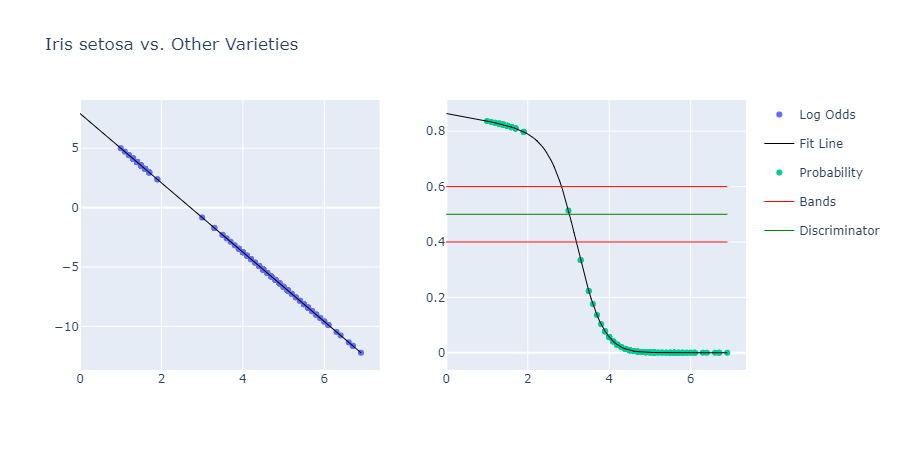

In [12]:
''' demonstrate what logistic regression is doing '''
# feature & class to demo
thisFeat = 'pet_len'
thisVariety = 'setosa'

# get data
thisClass = np.argwhere(varieties==thisVariety)[0,0]
demoData = np.atleast_2d(irisData[thisFeat].values).T
demoLabl = irisData.Class.values

# fit the logistic model for a single feature
LR = LogisticRegression(multi_class='ovr', max_iter=500, n_jobs=-1, random_state=42)
LR.fit(X=demoData, y=demoLabl)

# obtain result for a single class against the others
eqtn = '%0.2f + %0.2f \\times %s'%(LR.intercept_[thisClass], LR.coef_[thisClass],thisFeat.replace('_','\\_'))
logOdds = LR.intercept_[thisClass] + demoData*LR.coef_[thisClass]
probs = LR.predict_proba(X=demoData)[:,thisClass]
plotDat = pd.DataFrame(np.c_[demoData,logOdds,probs],columns=['data','logodd','prob'])

# create the fit lines
X = np.squeeze(np.linspace(0,max(demoData),100))
Yl = LR.intercept_[thisClass] + X*LR.coef_[thisClass]
Yp = LR.predict_proba(X=np.atleast_2d(X).T)[:,thisClass]
Yd = np.ones(shape=X.shape)

# plot
fig = plysub.make_subplots(rows=1, cols=2, print_grid=False,
                           subplot_titles=['$log\\_odds(%s) = %s$'%(thisVariety,eqtn),
                                           '$Probability(%s) = Logit(log\\_odds)$'%thisVariety])
fig['layout'].update(title = 'Iris %s vs. Other Varieties'%thisVariety, showlegend=True)
trcs = [go.Scatter(x=plotDat.data, y=plotDat.logodd, mode='markers', name='Log Odds'),
       go.Scatter(x=X,y=Yl, mode='lines', name='Fit Line', line={'color':'black','width':1}, legendgroup='Fit Line')]
for t in trcs:
    fig.append_trace(t,1,1)
trcs = [go.Scatter(x=plotDat.data, y=plotDat.prob, mode='markers', name='Probability'),
        go.Scatter(x=X,y=Yp, mode='lines', name='Fit Line', line={'color':'black', 'width':1},legendgroup='Fit Line', showlegend=False),
        go.Scatter(x=X,y=Yd*0.4, mode='lines', name='Bands', line={'color':'red', 'width':1}, legendgroup='Bands'),
        go.Scatter(x=X,y=Yd*0.5, mode='lines', name='Discriminator', line={'color':'green', 'width':1}),
        go.Scatter(x=X,y=Yd*0.6, mode='lines', name='Bands', line={'color':'red', 'width':1}, legendgroup='Bands', showlegend=False)]
for t in trcs:
    fig.append_trace(t,1,2)

plyoff.iplot(fig)

<a id=kernelsvm></a>
### Model Fisher's Iris Data with the Kernel Support Vector Machine
<a href=#top>Go to top</a> - <a href=#bottom>Go to bottom</a>
#### The Kernel Trick
The term *kernel* refers to a **Reproducing Kernel Hilbert Space**, first investigated by the mathematician Aronszajn in 1950. Applying a kernel to some data $X\in\mathbb{R}^{n\times p}$ corresponds to nonlinearly mapping $X$ into a higher dimensional feature space $F$, then taking the dot product of all *pairs of observations* in this space.

Instead of mapping the data then computing the dot product, we can simply compute a function $K\left(X,X\right)$ which is equivalent; this is called the *kernel trick*. Applying the kernel trick on a dataset of dimensions $n\times p$ results in an $n\times n$-sized **Gram matrix** $K$. Kernel-based machine learning techniques, such as kernel support vector machines, apply the specified statistical model to $K$, rather than $X$.

While inflating this dimensionality seems counter-intuitive, the benefit we get is that clusters / groups in data can often be better separated in the higher-dimensional kernel space. This is because the elements of the $K$ matrix are all functions of
distances between all pairs of observations in $X$.
<center><img src="./kerneltrick_separation.png" alt="Cluster Separation by the Kernel Trick" width="700"/></center>

There are several kernel functions. The seven most common are:
- Polynomial: $\left(\gamma x_i^\prime x_j+c_0\right)^d$ ($d=1$: linear, $d=2$: quadratic, $d=3$: cubic)
- Gaussian RBF: $\exp\left(-\gamma\left\Vert x_i-x_j\right\Vert^2\right)$
- Sigmoid: $\tanh\left(\gamma x_i^\prime x_j+c_0\right)$
- Laplace: $\exp\left(-\gamma\left\Vert x_i-x_j\right\Vert_1\right)$
- Chi-squared: $\exp\left(-\gamma\sum_i\left(\frac{\left(x_i-x_j\right)^2}{x_i+x_j}\right)\right)$

#### Support Vector Machines
A binary **Support Vector Machine** (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given data $X$ with known class labels $Y$, the algorithm outputs a hyperplane, estimated using the features in $X$, which optimally separates the observations by class, with the widest separation margin.
<center><img src="./svm.png" alt="Support Vector Machine" width="250"/></center>

The support vector machine is a generalization of discriminant analysis, in which $m\le n$ observations are selected to estimate the separating hyperplane defined as
$f\left(x_i\right) = b_0+\sum_{j=1}^p b_ix_i^j,\ j=1,\ldots, p$.

Under both discriminant analysis and support vector machines, the class prediction is defined by

$\hat{y}_i = \begin{cases}1 & f\left(x_i\right) >= 0\\
0 & f\left(x_i\right)<0\end{cases}$.

The intercept and coefficients of the discriminating hyperplane are optimized via quadratic programming:

$\begin{align}
\left(\mathbf{b}^*,b_0^*\right)=&\underset{\mathbf{b},b,\xi}{\min}\left[\frac{1}{2}\mathbf{b}^\prime\mathbf{b}+C\sum_{i=1}^n\xi_i^d\right]\text{, subject to}\\
&y_i\left(b_0+\mathbf{b}^\prime x_i\right) \ge1-\xi_i\\
&i=1,\ldots,m,\ C>0,\ \xi_i\ge0
\end{align}$

When $d=1$, we say the SVM is *L1 soft margin trained*, otherwise, it's *L2 soft margin trained*; $C$ is a regularization constant. This is the primal optimization problem; in many cases, the dual is easier to solve.

Note that the mathematical formulation actually requires $y_i\in[1,-1]$, but this is a trivial modification from the usual $[0,1]$ setup. The binary support vector machine can be extended to multinary classification in the same way as logistic regression.

#### Kernel Support Vector Machine
Extension to Kernel SVM is straightforward - instead of using the raw data $X$ to estimate the separating hyperplane (and later prediction), the kernelized data $K$ is used.

In [13]:
''' evaluate performance in Feature Space with 4 kernels '''
# get the data
data = irisData[features].values
labl = irisData.Class.values

# setup to use the kernels
kernels = {'linear':[{'degree':0, 'gamma':'auto', 'coef0':0},None,0.0], # no params needed
         'poly':[{'degree':2, 'gamma':1/p, 'coef0':0},None,0.0],        # all params needed
         'rbf':[{'degree':0, 'gamma':1/p, 'coef0':0},None,0.0],         # only gamma param needed
         'sigmoid':[{'degree':0, 'gamma':1/p, 'coef0':0},None,0.0]}     # degree param neeed
kernCnt = len(kernels)

# iterate over each kernel to fit & score
for kern,val in kernels.items():
    # define the estimator
    ksvm = SVC(kernel=kern, degree=val[0]['degree'], gamma=val[0]['gamma'], coef0=val[0]['coef0'], random_state=42)
    kernels[kern][1] = ksvm
    # fit & score
    ksvm.fit(X=data, y=labl)
    kernels[kern][2] = ksvm.score(X=data, y=labl)
    # store predictions
    irisData['%sSVMPred'%kern] = ksvm.predict(X=data)
    # talk
    print('Correct classification rate for %s = %0.2f%%'%(kern,100*val[2]))

Correct classification rate for linear = 98.00%
Correct classification rate for poly = 98.67%
Correct classification rate for rbf = 99.33%
Correct classification rate for sigmoid = 33.33%


In [14]:
''' evaluate the model '''
thisKernel = 'rbf'
# overall correct classification rate
classRate = kernels[thisKernel][2]
print('%s kernel svm Results\n%s\nCorrect Classification Rate: %0.2f%%'%(thisKernel,mysep,100*classRate))
# confusion matrix
confMat = myConfusionMatrix(labl, irisData['%sSVMPred'%thisKernel].values, range(k), varieties)
print('Confusion Matrix')
display(confMat)
print('Prediction Errors')
display(irisData[irisData.Class != irisData['%sSVMPred'%thisKernel]])

rbf kernel svm Results
++++++++++++++++++++++++++++++++++++++++++
Correct Classification Rate: 99.33%
Confusion Matrix


,setosa,versicolor,virginica
setosa,50,0,0
versicolor,0,49,1
virginica,0,0,50


Prediction Errors


,Class,Variety,Color,sep_len,sep_wid,pet_len,pet_wid,sep_len_x_sep_wid,sep_len_x_pet_len,sep_len_x_pet_wid,sep_wid_x_pet_len,sep_wid_x_pet_wid,pet_len_x_pet_wid,LRPred,linearSVMPred,polySVMPred,rbfSVMPred,sigmoidSVMPred
70,1,versicolor,#ff7f0e,5.9,3.2,4.8,1.8,18.88,28.32,10.62,15.36,5.76,8.64,2,2,1,2,2


The first three all outperformed logistic regression, but there is a possibility that these correct classification rates are all
inflated because the model has been *overfit* to the observed data, which was used for both model estimation and model evaluation.  We can fix this with *cross-validation*.

<a id=crossval></a>
### Machine Learning Technique - Cross-validation
<a href=#top>Go to top</a> - <a href=#bottom>Go to bottom</a>

Machine learning models are typically (as long as they are appropriate for the problem and data) very good at learning patterns in the data to which they are fit. This includes the random noise present in that data. A model that fits the data on which it was trained *too well* is said to be **overfit**. Overfitting is a problem because it limits the *generalizability* of a model to data other than that on which it was trained - it hurts subsequent *inference* and *prediction*. Overitting can be overcome by training and tuning a model on one dataset, then testing or evaluating it's performance on another dataset.

**Cross-validation** is a process by which a dataset is partitioned into smaller datasets that are used for:
- training / tuning a model
- testing the performance of a model
- evaluating multiple models or for early stopping (this is relatively recent, and optional)

Testing a machine learning model on data other than that on which it was trained is beneficial for generalizability because the random noise component of the testing set will typically be different than the random noise in the training set. This is exactly analagous to the situation when new data is subsequently presented to a model. There are several different forms of cross-validation, but no matter which is used, the data is cross-validated multiple times, and the empirical distribution of model results on the testing sets - mean prediction accuracy, for example - is evaluated. **k-fold** is one form of cross-validation.

In k-fold cross-validation, a dataset is partitioned (or *folded*) into training / testing sets $k$ times. In each partitioning, a sliding $\frac{n}{k}$ window of data is defined to be the testing set, with the remaining $n\times\left(1-\frac{1}{k}\right)$ observations the training set. This can be seen here, for $k=5$.
<center><img src="./kfoldcrossval_k5.png" alt="5-fold Cross-validation" width="500"/></center>

I tend not to use k-fold cross-validation, instead generally preferring **randomized cross-validation**. Randomized cross-validation does exactly what it sounds like - the modeler selects a proportion $p$ of the data to use for testing, and $n\times p$ observations are selected uniformly randomly from the dataset as the testing set. The remaining $n\left(1-p\right)$ observations become the training set. Because the dataset is partitioned randomly, we generally perform many such random partitions (more than k-fold). Randomized cross-validation with $p=0.20$ may look as shown here (grey arrows indicate testing set).
<center><img src="./randomcrossval_p20.png" alt="Random Cross-validation" width="400"/></center>

In the images above, the data is shown as data for a binary classification problem, indicated by the color of the markers. This should bring to mind a potential shortcoming of both forms of cross-validation shown here. If the data are being used for classification or clustering, and the proportion of data in any class are too small, it would be possible for a training / testing set to not represent all classes present in a dataset. This would hurt the generalizability which we hope to achieve by using cross-validation.

**Stratified cross-validation** solves this - for both k-fold and randomized methods - by folding / randomizing such that the proportion of data in each class in the dataset is preserved in training / testing sets.

In [15]:
''' overfitting to the observed data is an important concern, so apply cross-validation '''
# get the data
data = irisData[features].values
labl = irisData.Class.values

# set up the randomized cross-validator
splits = 100
testSize = 0.20
crossVal = StratifiedShuffleSplit(splits, test_size=testSize, random_state=42)

# perform the cross-validation model evaluation; if I only wanted the test score, could have used
# the cross_val_score object, but then the 4 kernels would not be evaluated on the same dataset each
# time, which could induce bias
crossValKernelScores = np.zeros((2,splits, kernCnt),dtype=float)
talkFreq = int(0.2*splits)
for i,(trn,tst) in enumerate(crossVal.split(data, labl)):
    # talk
    if (i+1) % talkFreq == 0:
        print('Random split %04d of %04d'%(i+1,splits))
    # get the training / testing data
    trnData = data[trn]; trnLabl = labl[trn]
    tstData = data[tst]; tstLabl = labl[tst]
    # iterate over each kernel to fit & score
    for j,(kern,val) in enumerate(kernels.items()):
        # define the estimator
        ksvm = SVC(kernel=kern, degree=val[0]['degree'], gamma=val[0]['gamma'], coef0=val[0]['coef0'], random_state=42)
        # fit & score
        ksvm.fit(X=trnData, y=trnLabl)
        crossValKernelScores[0,i,j] = ksvm.score(X=trnData, y=trnLabl)
        crossValKernelScores[1,i,j] = ksvm.score(X=tstData, y=tstLabl)
    
# summarize & talk
trnScores = pd.DataFrame(data=crossValKernelScores[0,:,:], columns=kernels.keys())
tstScores = pd.DataFrame(data=crossValKernelScores[1,:,:], columns=kernels.keys())
scores = trnScores.join(tstScores, how='inner', lsuffix='_trn', rsuffix='_tst').sort_index(axis=1)
display(scores.describe())

Random split 0020 of 0100
Random split 0040 of 0100
Random split 0060 of 0100
Random split 0080 of 0100
Random split 0100 of 0100


,linear_trn,linear_tst,poly_trn,poly_tst,rbf_trn,rbf_tst,sigmoid_trn,sigmoid_tst
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,1.000000e+02
mean,0.983500,0.960333,0.989750,0.962000,0.994167,0.948333,3.333333e-01,3.333333e-01
std,0.006037,0.035987,0.007287,0.035143,0.006097,0.038599,3.905356e-16,3.905356e-16
min,0.975000,0.833333,0.975000,0.866667,0.975000,0.833333,3.333333e-01,3.333333e-01
25%,0.983333,0.933333,0.983333,0.933333,0.991667,0.933333,3.333333e-01,3.333333e-01
50%,0.983333,0.966667,0.987500,0.966667,0.991667,0.966667,3.333333e-01,3.333333e-01
75%,0.985417,1.000000,1.000000,1.000000,1.000000,0.966667,3.333333e-01,3.333333e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.333333e-01,3.333333e-01


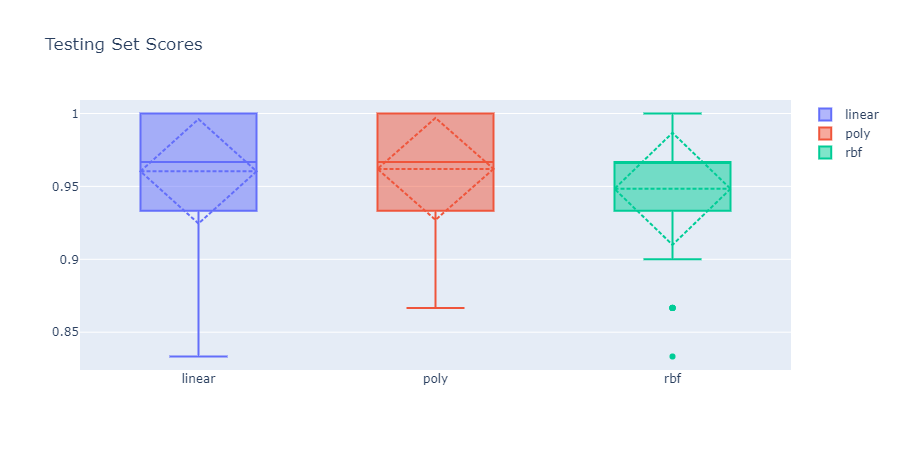

In [16]:
# show distribution of test scores by kernel
trc = []
for kern in tstScores.columns:
    # easier to see differences if sigmoid is skipped, as it sucks for this data
    if kern != 'sigmoid':
        thisData = irisData.loc[irisData.Variety==var,feat]
        trc.append(go.Box(y=tstScores[kern], name=kern, boxmean='sd', boxpoints='outliers'))
        
plyoff.iplot(go.Figure(data=trc, layout=go.Layout(title='Testing Set Scores')))

Looking at median testing set performance, it appears that the best SVM model for this dataset could use either a linear, quadratic polynomial, or Gaussian RBF kernel. But recall that there were some values (gamma, coef0, etc.) that I just set. Perhaps we could identify a truly "best" kernel with a different parameterization? We can evaluate this possibility with *hyperparameter tuning*.

<a id=gridsearch></a>
### Hyperparameter Tuning - Grid Search
<a href=#top>Go to top</a> - <a href=#bottom>Go to bottom</a>

All machine learning models learn patterns / relationships in an input dataset by setting **parameters**. For example, in the simple *ordinary least squares* (OLS) regression model

$y_i = b_0 + b_1x_i + \varepsilon_i$

the intercept ($b_0$) and slope ($b_1$) are model parameters. Parameters are used to encode some information about the data. In the case of OLS, the intercept informs us of the value expected for $y$ when $x=0$; the slope encodes the rate at which $y$ is expected to change for a unit change in $x$.

In addition to paramters, most machine learning models emply **hyperparameters**, which define the mathematical behavior of the model and / or it's optimization. Examples of hyperparameters include:
- learning rate generally used in gradient descent (a generic optimization method)
- regularization used in loss functions; for example L1 = $\sum_i\left\vert y - y_i \right\vert$ vs L2 = $\sum_i\left(y - y_i\right)^2$
- number of hidden layers and nodes per layer in a neural network
- depth of a decision tree
- number of clusters in k-means, mixture, or hierarchical clustering models

Hyperparameters take precedence over regular parameters in their impact on a model, which is reflected in the name: the prefix *hyper* comes from a greek word (ὑπέρ) meaning "over" or "above". They could also be seen as conveying information about a model - *metaparameters*, if you will. For example, the primary difference between *ridge regression* and *LASSO regression* is that the former applies a penalty of $\lambda\sum b_j^2$ of the regression coefficients, and the latter applies a penalty of $\lambda\sum\left\vert b_j\right\vert$. Hence the difference is that of L2 vs L1 regularization.

The optimal value for a hyperparameter (whether a continuous or discrete value) is often dependent upon the data. Hyperparameters are usually optimized by training multiple versions of a model with different values for the hyperparameters, then selecting the values that resulted in the best performance on a held-out testing dataset. This process is called **hyperparameter tuning**, and can be done in a few different ways, including Bayesian Optimization, Gradient Descent, Evolutionary Algorithms, Random Search, or Grid Search.

In **Grid Search** hyperparameter tuning, the goal is to search the possible values of a hyperparameter, seeking the best value, as efficiently as possible. This is usually done by generating a grid of values to test via uniform interval sampling from the space of possible values. The narrower the interval, the higher the likelihood of finding the best value. For a hyperparameter that can only take on values from a short enumeration of values, that enumeration is taken as the grid. If multiple hyperparameters are to be tuned simultaneously, the cartesian product of their grids is usually computed, so that all combinations of all grid values may be evaluated. This grid of grids is called the **hyperparameters space**.

Iteration with grid search is often a successful way to increase the chance of efficiently finding an optimal set of hyperparameters when the hyperparameters space is very large. This entails iterating over two steps (beginning with the entire space for all hyperparameters):
1. grid search the space to find the optimum
2. narrow the search space by "zooming in" around the previously-found optimum

This procedure is akin to **aliasing** in *signal processing*, and is one way to increase the efficiency of grid search.

When the number of hyperparameters being tuned simultaneously is large, with many values sampled in their grids, grid search can become too slow, even using aliasing. In that case, **random search** can be used. This procedure does exactly what it sounds like - the space of values is sampled, usually uniformly. With random search, we can often avoid iteration, instead sampling the hyperparameters space with more frequency. The benefit of this is demonstrated here:
<center><img src="./gridrandomsearch.png" alt="Grid vs Random Search" width="400"/></center>

While random search has been shown to outperform grid search when the hyperparameters space is large, this is at the expense of higher variability in the search results. Also, it is not guaranteed to find the best set of hyperparameters. This is ok, because grid search is also not guaranteed to find the best set of hyperparameters. To be fair, there is little in machine learning that comes with a guarantee.

For some continuously-valued hyperparameters, the space might be so large that a regular grid search over the range directly will not very efficently span what is generally considered to be the most important portion of the range. This would be the case for a parameter such as the *learning rate*, which often takes values spanning many orders of magnitude - $[0.0001, 1.0]$, for example. For hyperparameters such as this, a good strategy is to sample the grid in (base 10) log scale. This is demonstrated below by the series marked with <font color='red'>red x</font> and <font color='green'>green x</font>. The plot also demonstrates random search for the learning rate, in the series marked by <font color='red'>red &#9679;</font> and <font color='green'>green &#x25CF;</font>.

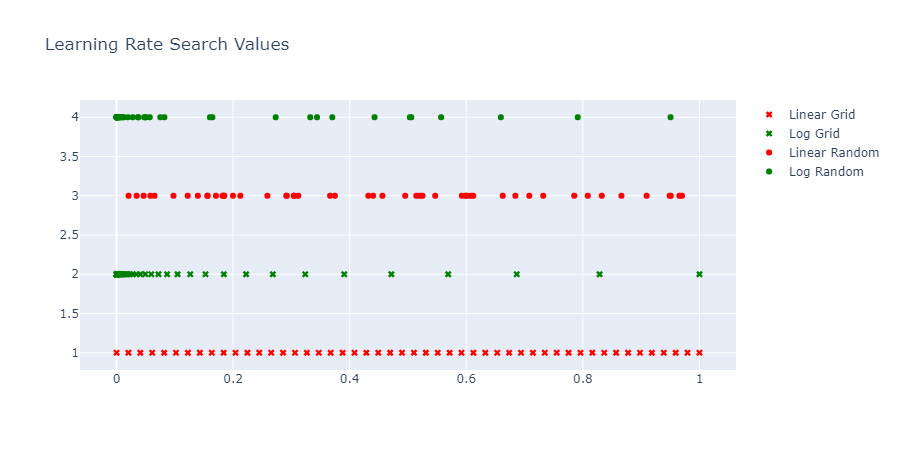

In [17]:
''' demonstrate linear- and log-scale random and grid search for a learning rate hyperparameter '''
np.random.seed(42)
granu = 50

# linear sampling
learn_rate_0 = np.linspace(0.0001, 1.0, num=granu, endpoint=True)
learn_rate_2 = np.random.uniform(0.0001, 1.000001, granu)

# log sampling
learn_rate_1 = 10**np.linspace(-4, 0, num=granu, endpoint=True)
learn_rate_3 = 10**(-4*np.random.rand(granu))

# plot
lrY = np.ones(shape=learn_rate_0.shape)
trcs = [go.Scatter(x=learn_rate_0, y=lrY*1, mode='markers', marker={'symbol':'x','color':'red'}, name='Linear Grid'),
        go.Scatter(x=learn_rate_1, y=lrY*2, mode='markers', marker={'symbol':'x','color':'green'}, name='Log Grid'),
        go.Scatter(x=learn_rate_2, y=lrY*3, mode='markers', marker={'symbol':'circle','color':'red'}, name='Linear Random'),
        go.Scatter(x=learn_rate_3, y=lrY*4, mode='markers', marker={'symbol':'circle','color':'green'}, name='Log Random')]
fig = go.Figure(data=trcs, layout = go.Layout(title='Learning Rate Search Values'))
plyoff.iplot(fig)

In [18]:
''' perform cross-validated grid search for kernel SVM '''
# get the data
data = irisData[features].values
labl = irisData.Class.values

# create the hyperparameter spaces - linear and polynomial kernels collapsed to polynomial with the degree parameter
params = [{'kernel':['poly'],'degree':[1,2,3],'gamma':[1/p,1,2],'coef0':[-1,0,1]},
          {'kernel':['rbf'],'gamma':[1/p,1,2],'degree':[3],'coef0':[0]},
          {'kernel':['sigmoid'],'gamma':[1/p,1,2],'coef0':[-1,0,1],'degree':[3]}]

# grid search and prediction
GSC = GridSearchCV(estimator=SVC(random_state=42), param_grid=params, cv=crossVal,
                   return_train_score=True, n_jobs=-1, verbose=0)
GSC.fit(X=data, y=labl)
bestKern = GSC.best_params_['kernel']
irisData['%sSVMPred_GSC'%bestKern] = GSC.predict(X=data)
classRate = GSC.score(X=data, y=labl)

# talk
print('Best Model Mean Test Set Correct Classification Rate = %0.2f%% (on all data = %0.2f%%)'%(100*GSC.best_score_,100*classRate))
for param in GSC.best_params_.keys():
    print('\t%s = %r'%(param,GSC.best_params_[param]))
# confusion matrix
confMat = myConfusionMatrix(labl, irisData['%sSVMPred_GSC'%bestKern].values, range(k), varieties)
print('Confusion Matrix')
display(confMat)

Best Model Mean Test Set Correct Classification Rate = 96.20% (on all data = 98.00%)
	coef0 = -1
	degree = 1
	gamma = 2
	kernel = 'poly'
Confusion Matrix


,setosa,versicolor,virginica
setosa,50,0,0
versicolor,0,48,2
virginica,0,1,49


In [19]:
''' review the data saved by GSC '''
print(GSC.cv_results_.keys())
# extract
parms = GSC.cv_results_['params']
tstMean = GSC.cv_results_['mean_test_score']
tstRank = GSC.cv_results_['rank_test_score']
trnMean = GSC.cv_results_['mean_train_score']

# combine
GSCResults = pd.DataFrame(parms).join(pd.DataFrame(np.c_[trnMean,tstMean,tstRank],columns=['Mean Train CCR','Mean Test CCR','Rank']))
GSCResults.sort_values(by=['kernel','Rank'], inplace=True)

# talk
display(GSCResults)

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_coef0', 'param_degree', 'param_gamma', 'param_kernel', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'split10_test_score', 'split11_test_score', 'split12_test_score', 'split13_test_score', 'split14_test_score', 'split15_test_score', 'split16_test_score', 'split17_test_score', 'split18_test_score', 'split19_test_score', 'split20_test_score', 'split21_test_score', 'split22_test_score', 'split23_test_score', 'split24_test_score', 'split25_test_score', 'split26_test_score', 'split27_test_score', 'split28_test_score', 'split29_test_score', 'split30_test_score', 'split31_test_score', 'split32_test_score', 'split33_test_score', 'split34_test_score', 'split35_test_score', 'split36_test_score', 'split37_test_score', 'split38_test_score',

,coef0,degree,gamma,kernel,Mean Train CCR,Mean Test CCR,Rank
2,-1,1,2.0,poly,0.984167,0.962000,1.0
3,-1,2,0.1,poly,0.989750,0.962000,1.0
11,0,1,2.0,poly,0.984167,0.962000,1.0
12,0,2,0.1,poly,0.989750,0.962000,1.0
20,1,1,2.0,poly,0.984167,0.962000,1.0
21,1,2,0.1,poly,0.989917,0.961333,6.0
1,-1,1,1.0,poly,0.983500,0.960333,7.0
10,0,1,1.0,poly,0.983500,0.960333,7.0
19,1,1,1.0,poly,0.983500,0.960333,7.0
0,-1,1,0.1,poly,0.972083,0.957333,10.0


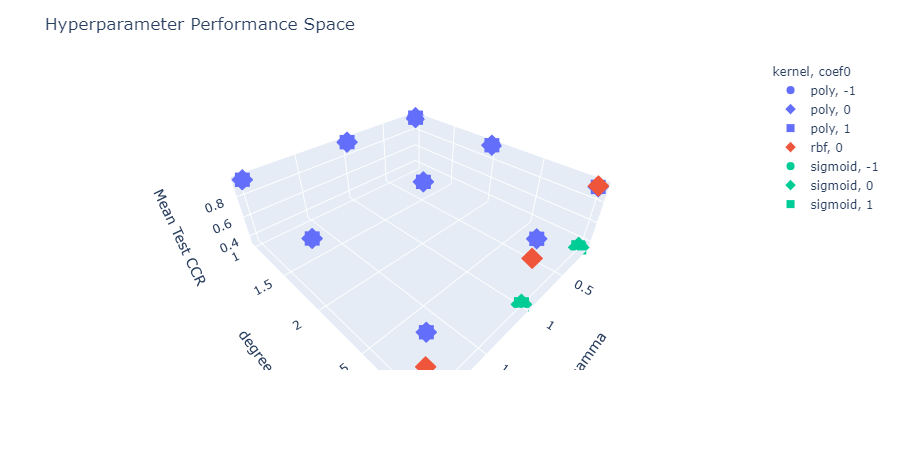

In [20]:
''' review the hyperparameter performance space '''
fig = px.scatter_3d(GSCResults, x='gamma', y='degree', z='Mean Test CCR', color='kernel', symbol='coef0')
fig.update_layout(title='Hyperparameter Performance Space')
plyoff.iplot(fig)

These results suggest that the best predictive model may be a linear polynomial kernel SVM with $\gamma=2$ (though other models seem to perform identically). This is for fitting a model with $p=10$ features - the original four measurements plus the 6 pairwise interactions we engineered. Perhaps a model fit to a subset of these features would perform better, or at least perform similarly while being simpler? We can find out with *feature selection*.

<a id=featsel></a>
### Feature Selection - Combinatorial Enumeration
<a href=#top>Go to top</a> - <a href=#bottom>Go to bottom</a>

Statistical modelers have been trying models on subsets of features for almost as long as statistical modeling (most of what we call "machine learning" is actually statistical modeling) has been around. Perhaps unimaginably, we call the process of selecting a subset of available features **feature selection**. In feature selection, we use some procedure to generate subsets of the existing features, fit a model to them, and evaluate that model to find an optimal subset. The goal of feature selection is generally to balance two considerations: model performance and *model complexity*. It is generally beneficial for a model to be simpler - to use fewer features, for example. We often prefer a simpler model, even if it performs slightly worse than a more complex model. This follows the principle of *occam's razor*.

By this point in the knowledge share series, it will come as no surprise when I say that there are several ways to perform feature selection. Consider the oft-followed process during regression modeling of looking at p-values to remove "unimportant" features from a model.

In [21]:
''' demonstrate using p-values for feature selection in regressin '''
# load the diabeted data - try print(diabetes['DESCR']) for more information
diabetes = load_diabetes()
dataD = diabetes['data']
targD = diabetes['target']
featD = diabetes['feature_names']
nD,pD = dataD.shape

# fit the saturated model and predict
lin = LinearRegression(n_jobs=-1)
pred = lin.fit(X=dataD, y=targD).predict(X=dataD)

# prepare the coefficients and data prepended with the model intercept
coefs = lin.coef_.tolist(); coefs.insert(0, lin.intercept_)
xwones = np.c_[np.ones(shape=(nD, 1), dtype=float), dataD]
featD.insert(0, 'Constant')

# compute the feature coefficient statistics: standard error, test stat, p-value, decision
alpha = 0.005
critVal = stats.t.ppf(1-alpha/2, df=nD-pD-1)
MSE = np.sum((targD - pred)**2)/(nD - pD - 1)
coefStdErrs = np.sqrt(MSE*(np.linalg.inv(np.dot(xwones.T, xwones)).diagonal()))
coefTestStats = coefs / coefStdErrs
coefPVals = [2*(1 - stats.t.cdf(abs(ts), n-1)) for ts in coefTestStats]
coefDecide = [['Reject','Keep'][int(pval<p)] for pval in coefPVals]

# put it all together and talk
regStats = pd.DataFrame(index=featD, data={'Coefficient':np.round(coefs, 3), 'Standard Error':np.round(coefStdErrs, 3),
                                           'Test Statistic':np.round(coefTestStats, 3), 'P-value':np.round(coefPVals, 3),
                                           'Decision':coefDecide}).sort_values(by=['P-value'])
print("Student's t critical value for alpha=%0.4f = ±%0.2f"%(alpha, critVal))
display(regStats)

Student's t critical value for alpha=0.0050 = ±2.82


,Coefficient,Standard Error,Test Statistic,P-value,Decision
Constant,152.133,2.576,59.061,0.000,Keep
sex,-239.819,61.222,-3.917,0.000,Keep
bmi,519.840,66.534,7.813,0.000,Keep
bp,324.390,65.422,4.958,0.000,Keep
s5,751.279,171.902,4.370,0.000,Keep
s1,-792.184,416.684,-1.901,0.059,Keep
s2,476.746,339.035,1.406,0.162,Keep
s4,177.064,161.476,1.097,0.275,Keep
s6,67.625,65.984,1.025,0.307,Keep
s3,101.045,212.533,0.475,0.635,Keep


Starting with the fully *saturated model* - with all features included - the modeler would iteratively
- remove the last feature from the model
- re-fit and score the model

until obtaining a model with only "Keep" in the last column. There are issues with following this procedure, but that's a conversation for another day.

This iterative procedure is generally formalized in what's called *stepwise regression*, and is usually driven by *model criteria* such as $R^2$, the $F-$statistic, AIC, BIC, Mallows' $C_p$, etc. The three main ways of performing stepwise regression are:
- *Forward Selection*: Features are added to a model sequentially, in the order of most improvement in the model criterion
- *Backward Elimination*: The saturated model is fit, then features are selected for removal sequentially, in the order of least degradation of the model criterion.
- *Bidirectional Elimination*: A combination of forward selection & backward elimination, which allows features to both enter & exit the model in each iteration.

Of course, the same kind of stepwise procedures could be used for most any machine learning model, as long as there is an approriate model criterion to drive the selection / elimination.

Choosing the correct model criterion is of special importance, but is often not done correctly. For example, of the list of criteria in the preceding paragram, only AIC, BIC, and Mallows' $C_p$ penalize a subset regression model for model complexity. The others, which are used most, are all about the model performance - no balance. In the case of a classification model the correct classification rate criterion generally used to assess models would also fail in this aspect.

The *genetic algorithm* can be used for a more advanced form of feature selection. Genetic algorithms are a class of general optimization procedures which operate much like natural selection on a set of solutions to a problem (*population* of *individuals*). For the problem of feature selection from a set of $p$ features, each individual is a $p-$length binary string indicating that a feature is in that solution (1) or out of it (0). For our Fisher's Iris Data example, one such solution could be $\left[1010010000\right]$, which would indicate selecting only the Sepal Length, Petal Length, and their pairwise interaction feature. As with stepwise methods, a model criterion, or *objective function* is needed to optimize. The GA as a feature selection optimizer is flexible, and can converge to an optimal, or near-optimal set of features relatively quickly. However, it also requires many executions of the objective function, and is quite computationally expensive, so generally most useful for datasets with many features.

A simpler way to perform feature selection, that guarantees finding the most optimal subset of features is *combinatorial enumeration* - a.k.a. **brute force**. Combinatorial enumeration does exactly what it sounds like - the model is evauated on the enumeration of all possible combinations of features. This is no mean feat, as the number of ways to combine $p$ features is exponential in $p$; there are $2^p-1$ possible subsets. This is demonstrated below.

There is one final consideration when the features in a dataset include compound features such as higher-order ($x_i^2$) or interaction ($x_i\times x_j$) terms. In this case, we often want to ensure that feature selection selects all simple features involved in any selected compound feature - we want to ensure *hierarchy holds*. For our Fisher's Iris Data example, the argument of hierarchy would insist that the subset $\left[0000000011\right]$ (Sepal Width $\times$ Petal Width & Petal Length $\times$ Petal Width) is invalid, but $\left[0111000011\right]$ (including the three simple features) is valid. While the importance of feature hierarchy in feature selection is, in fact, debated, it is clearly reasonable from the perspective of model interpretability.

In [22]:
''' demonstrate exponential growth in feature subsets '''
ps = [2,3,4,5,10,20,50,100]
display(pd.DataFrame(index=ps, data=[2**p - 1 for p in ps], columns=['subsets']))

,subsets
2,3
3,7
4,15
5,31
10,1023
20,1048575
50,1125899906842623
100,1267650600228229401496703205375


In [23]:
''' generate all subsets of features '''
hierarchy = True

# generate all subsets
subsets = VarSubset(p)[0][1:] # function I originally wrote in MATLAB in 2006!
subsetCount = len(subsets)
sizeCounts = pd.Series(data=np.sum(subsets, axis=1)).value_counts().sort_index()
# talk
print('%d feature subsets, counting by subset size'%subsetCount)
display(sizeCounts)

# dispose of hierarchy-flouting subsets, maybe
valids = [False]*subsetCount
if hierarchy:
    for i, subset in enumerate(subsets):
        # simple vs compound features
        simps = subset[:4]
        comps = subset[4:]
        # are there any compound features selected?
        if comps.sum()>0:
            # get the simple features expected from all compounds
            expect = np.any(depends[:,comps], axis=1)
            # check that all are selected
            valids[i] = np.all(expect == simps)
        else:
            # only simples are automatically valid
            valids[i] = True
    subsets = subsets[valids,:]
    subsetCount = len(subsets)
    print('%d valid subsets'%subsetCount)

1023 feature subsets, counting by subset size


1      10
2      45
3     120
4     210
5     252
6     210
7     120
8      45
9      10
10      1
dtype: int64

78 valid subsets


In [24]:
''' perform combinatorial enumeration feature selection with cross-validated grid search for kernel SVM '''
splits = 10 # use fewer cross-validation splits to speed things up, or rather, make them less slow
# evaluate all subset models
fsModels = [None]*subsetCount
fsParams = [None]*subsetCount
fsScores = [0]*subsetCount
talkFreq = max(4, int(0.004*subsetCount))
for i, sub in enumerate(subsets):
    subStr = ''.join(sub.astype(int).astype(str))
    # define the gsc object
    fsModels[i] = GridSearchCV(estimator=SVC(random_state=42), param_grid=params,
                             cv=StratifiedShuffleSplit(splits, test_size = 0.2, random_state=42),
                             n_jobs=-1, verbose=0)    
    # cross-validated grid search
    fsModels[i].fit(X=data[:,sub], y=labl)
    # save the best model & score per subset
    fsParams[i] = fsModels[i].best_params_
    fsScores[i] = fsModels[i].best_score_ # best Mean Test Set Correct Classification Rate
    # get the global best so far
    gloBstInd = np.argmax(fsScores)
    gloBstScr = fsScores[gloBstInd]
    gloBstSubStr = ''.join(subsets[gloBstInd,:].astype(int).astype(str))
    # talk
    if ((i+1) % talkFreq == 0) | (i == 0) | (i == subsetCount-1):
        print('Subset %04d of %04d: %s(%s) = %0.4f; Global Best: %s = %0.4f'%\
              (i+1, subsetCount, fsParams[i]['kernel'], subStr, fsScores[i], gloBstSubStr, gloBstScr))

Subset 0001 of 0078: poly(0001000000) = 0.9533; Global Best: 0001000000 = 0.9533
Subset 0004 of 0078: poly(1000000000) = 0.7367; Global Best: 0001000000 = 0.9533
Subset 0008 of 0078: poly(0110000000) = 0.9533; Global Best: 1010000000 = 0.9567
Subset 0012 of 0078: poly(1001001000) = 0.9500; Global Best: 0011000001 = 0.9633
Subset 0016 of 0078: rbf(1101000000) = 0.9567; Global Best: 1011000000 = 0.9767
Subset 0020 of 0078: poly(0110000100) = 0.9567; Global Best: 1011000000 = 0.9767
Subset 0024 of 0078: poly(0111000011) = 0.9567; Global Best: 1011000000 = 0.9767
Subset 0028 of 0078: poly(1110010100) = 0.9567; Global Best: 1011000000 = 0.9767
Subset 0032 of 0078: poly(1011010001) = 0.9600; Global Best: 1011000000 = 0.9767
Subset 0036 of 0078: poly(1111100001) = 0.9667; Global Best: 1011000000 = 0.9767
Subset 0040 of 0078: poly(1011011001) = 0.9633; Global Best: 1011000000 = 0.9767
Subset 0044 of 0078: poly(1111010011) = 0.9600; Global Best: 1011000000 = 0.9767
Subset 0048 of 0078: poly(111

In [25]:
''' get final best model results '''
# now find the subset with the best score, then get that subset, model, & it's parameters, and perform cross-validation on it
best = np.argmax(fsScores)
bestSubset = subsets[best,:]
bestParams = fsParams[best]
bestModel = fsModels[best]
bestModelScores = cross_val_score(bestModel, X=data[:,bestSubset], y=labl, cv=crossVal)

# talk
print('Best Subset of Features: %r\nBest Kernel SVM Model:'%[f for f, s in zip(features, bestSubset) if s])
for param, value in bestParams.items():
    print('\t%s = %r'%(param, value))
print('Distribution of Test Set Correct Classification Rates')
display(pd.Series(data=bestModelScores, name=bestParams['kernel']).describe())

Best Subset of Features: ['sep_len', 'pet_len', 'pet_wid']
Best Kernel SVM Model:
	coef0 = -1
	degree = 1
	gamma = 1
	kernel = 'poly'
Distribution of Test Set Correct Classification Rates


count    100.000000
mean       0.963667
std        0.031102
min        0.866667
25%        0.933333
50%        0.966667
75%        1.000000
max        1.000000
Name: poly, dtype: float64

In [26]:
''' review model performance'''
# put together the results
resultsBySize = pd.DataFrame(data={'Size':np.sum(subsets, axis=1), 'Score':fsScores,
                                   'Subset':[[f for f, s in zip(features, sub) if s] for sub in subsets],
                                   'Kernel':[p['kernel'] for p in fsParams],
                                   'Degree':[p['degree'] for p in fsParams]}).sort_values(by=['Size', 'Score'], ascending=[True,False])
# and also filter to get the best by size
bestBySize = resultsBySize[~resultsBySize.duplicated(subset=['Size'], keep='first')]

# talk
display(bestBySize)
display(resultsBySize)

,Size,Score,Subset,Kernel,Degree
0,1,0.953333,[pet_wid],poly,1
8,2,0.963333,"[pet_len, pet_wid]",poly,1
13,3,0.976667,"[sep_len, pet_len, pet_wid]",poly,1
20,4,0.976667,"[sep_len, sep_wid, pet_len, pet_wid]",poly,1
21,5,0.963333,"[sep_wid, pet_len, pet_wid, sep_wid_x_pet_len, sep_wid_x_pet_wid]",rbf,3
35,6,0.966667,"[sep_len, sep_wid, pet_len, pet_wid, sep_len_x_sep_wid, pet_len_x_pet_wid]",poly,1
49,7,0.973333,"[sep_len, sep_wid, pet_len, pet_wid, sep_len_x_sep_wid, sep_wid_x_pet_len, pet_len_x_pet_wid]",rbf,3
61,8,0.966667,"[sep_len, sep_wid, pet_len, pet_wid, sep_len_x_sep_wid, sep_len_x_pet_len, sep_wid_x_pet_wid, pet_len_x_pet_wid]",poly,1
74,9,0.963333,"[sep_len, sep_wid, pet_len, pet_wid, sep_len_x_sep_wid, sep_len_x_pet_len, sep_len_x_pet_wid, sep_wid_x_pet_wid, pet_len_x_pet_wid]",poly,1
77,10,0.963333,"[sep_len, sep_wid, pet_len, pet_wid, sep_len_x_sep_wid, sep_len_x_pet_len, sep_len_x_pet_wid, sep_wid_x_pet_len, sep_wid_x_pet_wid, pet_len_x_pet_wid]",poly,1


,Size,Score,Subset,Kernel,Degree
0,1,0.953333,[pet_wid],poly,1
1,1,0.950000,[pet_len],poly,2
3,1,0.736667,[sep_len],poly,2
2,1,0.573333,[sep_wid],rbf,3
8,2,0.963333,"[pet_len, pet_wid]",poly,1
5,2,0.956667,"[sep_len, pet_len]",poly,2
6,2,0.953333,"[sep_len, pet_wid]",rbf,3
7,2,0.953333,"[sep_wid, pet_len]",poly,1
9,2,0.953333,"[sep_wid, pet_wid]",rbf,3
4,2,0.786667,"[sep_len, sep_wid]",poly,1


So after all this, if we want to use a single model to predict the variety of an iris flower, it appears that we only need to measure the length of the sepal and petal, and the width of the petal, then apply a SVM model, using a linear kernel with coef0 $= -1$ and $\gamma = 1$. Of course, this is from having only reviewed Logistic Regression and Support Vector Machines (though, to be fair, we did not do the extensive machine learning with Logistic Regression).

The reason why there are different machine learning models is that they have their own strengths & weaknesses. There is no model that will always be best for all datasets that can ever exist (though a Deep Learning Neural Networks may someday be that). Can we create a model that combines multiple models together, uses the strengths of some to combat the weaknesses of others? Yes we can; this is called *ensemble modeling*.

<a id=ensemble></a>
### Ensemble Modeling
<a href=#top>Go to top</a> - <a href=#bottom>Go to bottom</a>

We've all heard the phrase "less is more", but that is not always the case in machine learning. Founded on the idea that the only thing better than a machine learning model is two machine learning models (gratuitous *Water Boy* reference!), the **ensemble model**, which is literally an ensemble of models, proves this. Ensemble models are used for multiple reasons:
- allow the strengths of some models to overcome the weakness of others
- reduce model variance
- avoid overfitting
- reduce correlation among models
- reduce bias

I began modeling with ensemble models in the early 2000's, having never heard of the term. At the time, I was developing daily trading model for *index mutual funds*. We reasoned that we could make more robust and more accurate predictions on the direction of the market if we used a set of models that diversified by instrument, methodology, source, and frequency. An important component of an ensemble model is the *voting mechanism* - this defines how you handle when the component models disagree. For trading, I developed an allocation system that allocated a fixed number of votes among the component models based on the recent performance of their signals. As compared to any of the component models, the resultant ensemble model made higher returns, spent less time in drawdowns, and experienced lower volatility over many years of bull, bear, and whipsaw markets. This is called *market neutrality*.

Perhaps the simplest way to create a machine learning ensemble model is to simply fit $M$ models to a dataset, and combine their predictions. In the case of predicting a continuous response, the voting mechanism could simply average the predicted values. For classification, we could pick the most often predicted class, choose the class predicted by the model that had the highest predicted probability, or combine & rebalance all models' class probabilities. For example, we could fit both the Logistic Regression and Kernel SVM models we've already seen to the Fisher Iris Data to predict the flower varieties. In my prior work on predicting North Sea field production volumes, I created an ensemble model that averaged together *elastic net*, *gradient boosting*, and *adaptive boosting* regression models. This was then treated as a single model, and ensembled together with the WM forecasts using a static .75 / .25 weighted average.
<center><img src=./ensemble_architecture.png alt="Ensemble Architecture" width=700/></center>

In machine learning, there are three major ideas behind ensemble models: *bagging*, *boosting*, and *stacking*. Bagging, originally a contraction of the term *bootstrap aggregating*, works by combining many models together, in which each one is fit to a *bootstrapped* dataset. Bootstrapping is the process of randomly selecting - with replacement - a subset of observations from a dataset. In addition to this, bagging can also refer to *attribute bagging* or *feature bagging*, in which each model is fit to a randomly-selected subset of the features. The *random forest* model typically uses both observation and feature bagging. Boosting is a complex and precisely-defined mathematical mechanism that typically works by fitting a series of models to a dataset, iterating over two steps:
- fit a *weak learner* model
- reweight observations, giving higher weighting to those that the model got most wrong.

Perhaps a stacked ensemble model could be almost thought of as *psuedo-boosting*, though there's no weighting of observations. There are different ways to create a stacked ensemble model, but one would be to use multiple models create predictions, then use those predictions as features for another model. This could include, for example, fitting a regression model to some data, then fitting a second regression model to the residuals to predict the same response.

The only downsides to ensemble models that I can think of is the additional computational time, additional complexity, and possible difficulty interpreting / explaining results.

Scikit-learn documentation currently lists almost 20 [ensemble methods](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble).

In [21]:
''' demonstrate voting classifier '''
# component models
models = ['Ensemble','Logistic Regression', 'Kernel SVM']
LGRG = LogisticRegression(multi_class='ovr', max_iter=500, n_jobs=-1, random_state=42)
KSVM = SVC(kernel=GSC.best_params_['kernel'], degree=GSC.best_params_['degree'],
           gamma=GSC.best_params_['gamma'], coef0=GSC.best_params_['coef0'],
           probability=True, random_state=42) # probability=True needed if votRule='soft'

# setup the voting classifier
votRule = 'soft' # hard = uses predicted class labels for majority voting; soft = uses predicted probabilities
votClas = VotingClassifier(estimators=[('Logistic Regression', LGRG), ('Kernel SVM', KSVM)], voting=votRule, n_jobs=-1)

# perform the cross-validation model evaluation
crossValScores = np.zeros((2, crossVal.n_splits, 3), dtype=float)
talkFreq = int(0.2*crossVal.n_splits)
for i,(trn, tst) in enumerate(crossVal.split(data, labl)):
    # talk
    if (i+1) % talkFreq == 0:
        print('Random split %04d of %04d'%(i+1,splits))
    # get the training / testing data
    trnData = data[trn]; trnLabl = labl[trn]
    tstData = data[tst]; tstLabl = labl[tst]
    # fit & score
    votClas.fit(X=trnData, y=trnLabl)
    crossValScores[0,i,0] = votClas.score(X=trnData, y=trnLabl)
    crossValScores[1,i,0] = votClas.score(X=tstData, y=tstLabl)
    # do the same for the component models
    crossValScores[0,i,1] = votClas.named_estimators_['Logistic Regression'].score(X=trnData, y=trnLabl)
    crossValScores[1,i,1] = votClas.named_estimators_['Logistic Regression'].score(X=tstData, y=tstLabl)
    crossValScores[0,i,2] = votClas.named_estimators_['Kernel SVM'].score(X=trnData, y=trnLabl)
    crossValScores[1,i,2] = votClas.named_estimators_['Kernel SVM'].score(X=tstData, y=tstLabl)
    
# summarize & talk
trnScores = pd.DataFrame(data=crossValScores[0,:,:], columns=models)
tstScores = pd.DataFrame(data=crossValScores[1,:,:], columns=models)
scores = trnScores.join(tstScores, how='inner', lsuffix='_trn', rsuffix='_tst').sort_index(axis=1)
display(scores.describe())

Random split 0020 of 0100
Random split 0040 of 0100
Random split 0060 of 0100
Random split 0080 of 0100
Random split 0100 of 0100


,Ensemble_trn,Ensemble_tst,Kernel SVM_trn,Kernel SVM_tst,Logistic Regression_trn,Logistic Regression_tst
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.983917,0.964333,0.984167,0.962000,0.981750,0.958333
std,0.006406,0.034898,0.005981,0.037611,0.006668,0.038013
min,0.966667,0.833333,0.975000,0.833333,0.966667,0.833333
25%,0.983333,0.933333,0.983333,0.933333,0.975000,0.933333
50%,0.983333,0.966667,0.983333,0.966667,0.983333,0.966667
75%,0.991667,1.000000,0.991667,1.000000,0.983333,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
''' demonstrate stacking classifier '''
# setup the stacked classifier (using the same models as the voting classifier)
crossValInput = 5 # this indicates 5-fold stratified cv
passThrough = True # true = final trained on X + predictions, false = final trained only on predictions
finalEstim = DecisionTreeClassifier(random_state=42)
stkClas = StackingClassifier(estimators=[('Logistic Regression', LGRG), ('Kernel SVM', KSVM)],
                             cv=crossValInput, passthrough=passThrough, final_estimator=finalEstim,
                             n_jobs=-1)

# perform the cross-validation model evaluation
crossValScores = np.zeros((2, crossVal.n_splits, 3), dtype=float)
talkFreq = int(0.2*crossVal.n_splits)
for i,(trn, tst) in enumerate(crossVal.split(data, labl)):
    # talk
    if (i+1) % talkFreq == 0:
        print('Random split %04d of %04d'%(i+1,splits))
    # get the training / testing data
    trnData = data[trn]; trnLabl = labl[trn]
    tstData = data[tst]; tstLabl = labl[tst]
    # fit & score
    stkClas.fit(X=trnData, y=trnLabl)
    crossValScores[0,i,0] = stkClas.score(X=trnData, y=trnLabl)
    crossValScores[1,i,0] = stkClas.score(X=tstData, y=tstLabl)
    # do the same for the component models
    crossValScores[0,i,1] = stkClas.named_estimators_['Logistic Regression'].score(X=trnData, y=trnLabl)
    crossValScores[1,i,1] = stkClas.named_estimators_['Logistic Regression'].score(X=tstData, y=tstLabl)
    crossValScores[0,i,2] = stkClas.named_estimators_['Kernel SVM'].score(X=trnData, y=trnLabl)
    crossValScores[1,i,2] = stkClas.named_estimators_['Kernel SVM'].score(X=tstData, y=tstLabl)
    
# summarize & talk
trnScores = pd.DataFrame(data=crossValScores[0,:,:], columns=models)
tstScores = pd.DataFrame(data=crossValScores[1,:,:], columns=models)
scores = trnScores.join(tstScores, how='inner', lsuffix='_trn', rsuffix='_tst').sort_index(axis=1)
display(scores.describe())

Random split 0020 of 0100
Random split 0040 of 0100
Random split 0060 of 0100
Random split 0080 of 0100
Random split 0100 of 0100


,Ensemble_trn,Ensemble_tst,Kernel SVM_trn,Kernel SVM_tst,Logistic Regression_trn,Logistic Regression_tst
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.985833,0.942667,0.984167,0.962000,0.981750,0.958333
std,0.013990,0.036416,0.005981,0.037611,0.006668,0.038013
min,0.950000,0.866667,0.975000,0.833333,0.966667,0.833333
25%,0.975000,0.933333,0.983333,0.933333,0.975000,0.933333
50%,0.991667,0.933333,0.983333,0.966667,0.983333,0.966667
75%,1.000000,0.966667,0.991667,1.000000,0.983333,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Logistic Regression_setosa = 0.50
pet_len_x_pet_wid = 0.45
sep_wid_x_pet_wid = 0.03
sep_len_x_pet_wid = 0.01
sep_wid_x_pet_len = 0.00
sep_len_x_pet_len = 0.00
sep_len_x_sep_wid = 0.00
pet_wid = 0.00
pet_len = 0.00
sep_wid = 0.00
sep_len = 0.00
Kernel SVM_virginica = 0.00
Kernel SVM_versicolor = 0.00
Kernel SVM_setosa = 0.00
Logistic Regression_virginica = 0.00
Logistic Regression_versicolor = 0.00


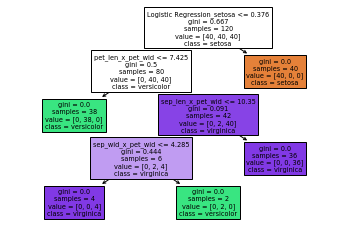

In [23]:
''' plot the decision tree & show feature importances from the last stacking classifier '''
# need to create a list of features, I *think* with passthrough=True that the features in order are
# Logistic Regression class probs, Kernel SVM class probs, original features
feats = ['_'.join(mv) for mv in product(models[1:],varieties)]
feats.extend(features)

# show the feature importances
featImports = [(f, i) for f, i in zip(feats, stkClas.final_estimator_.feature_importances_)]
featImports.sort(key=lambda x:x[1])
for (f, i) in featImports[::-1]:
    print('%s = %0.2f'%(f,i))

# plot
_ = plot_tree(stkClas.final_estimator_, feature_names=feats, class_names=varieties, filled=True)

In [24]:
''' demonstrate random forest '''
# setup the random forest classifier
numberTrees = 100
RF = RandomForestClassifier(n_estimators=numberTrees, random_state=42, n_jobs=-1)

# perform the cross-validation model evaluation
# cross-validation is probably not strictly required, since each decision tree sees a different sample
crossValScores = np.zeros((crossVal.n_splits, 2), dtype=float )
talkFreq = int(0.2*crossVal.n_splits)
for i,(trn, tst) in enumerate(crossVal.split(data, labl)):
    # talk
    if (i+1) % talkFreq == 0:
        print('Random split %04d of %04d'%(i+1,splits))
    # get the training / testing data
    trnData = data[trn]; trnLabl = labl[trn]
    tstData = data[tst]; tstLabl = labl[tst]
    # fit & score
    RF.fit(X=trnData, y=trnLabl)
    crossValScores[i,0] = RF.score(X=trnData, y=trnLabl)
    crossValScores[i,1] = RF.score(X=tstData, y=tstLabl)

# summarize & talk
trnScores = pd.DataFrame(data=crossValScores[:,0], columns=['Random Forest'])
tstScores = pd.DataFrame(data=crossValScores[:,1], columns=['Random Forest'])
scores = trnScores.join(tstScores, how='inner', lsuffix='_trn', rsuffix='_tst').sort_index(axis=1)
display(scores.describe())
# final random forest performance
print('Correct Classification Rate: %0.3f%%'%(100*crossValScores[-1,1]))
# final random forest overall feature importances
featImports = [(f, i) for f, i in zip(features, RF.feature_importances_)]
featImports.sort(key=lambda x:x[1])
for (f, i) in featImports[::-1]:
    print('%s = %0.2f'%(f,i))

Random split 0020 of 0100
Random split 0040 of 0100
Random split 0060 of 0100
Random split 0080 of 0100
Random split 0100 of 0100


,Random Forest_trn,Random Forest_tst
count,100.0,100.000000
mean,1.0,0.954667
std,0.0,0.034660
min,1.0,0.833333
25%,1.0,0.933333
50%,1.0,0.966667
75%,1.0,0.966667
max,1.0,1.000000


Correct Classification Rate: 93.333%
pet_len_x_pet_wid = 0.29
sep_len_x_pet_wid = 0.18
pet_wid = 0.16
pet_len = 0.15
sep_len_x_pet_len = 0.09
sep_wid_x_pet_wid = 0.08
sep_wid_x_pet_len = 0.05
sep_len = 0.01
sep_wid = 0.00
sep_len_x_sep_wid = 0.00


Best Tree Correct Classification Rate: 100.000%
sep_len_x_pet_wid = 0.56
pet_len_x_pet_wid = 0.38
sep_wid_x_pet_wid = 0.03
sep_len_x_pet_len = 0.02
pet_wid = 0.02
sep_wid_x_pet_len = 0.00
sep_len_x_sep_wid = 0.00
pet_len = 0.00
sep_wid = 0.00
sep_len = 0.00


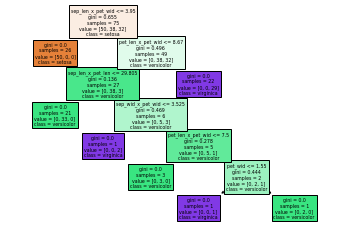

In [25]:
''' get some information from the last random forest '''
# choose the best tree, based on the last testing set
treeScores = [atree.score(X=tstData, y=tstLabl) for atree in RF.estimators_]
bestTree = np.argsort(treeScores)[-1]    # just reusing variable
bestTreeScore = treeScores[bestTree]
bestTree = RF.estimators_[bestTree]
print('Best Tree Correct Classification Rate: %0.3f%%'%(100*bestTreeScore))

# show the feature importances
featImports = [(f, i) for f, i in zip(features, bestTree.feature_importances_)]
featImports.sort(key=lambda x:x[1])
for (f, i) in featImports[::-1]:
    print('%s = %0.2f'%(f,i))

# plot it
_ = plot_tree(bestTree, feature_names=features, class_names=varieties, filled=True)

<a id=bottom></a>Done! <a href=#top>Go to top</a>